# Smokes Friends Cancer

A classic example of Statistical Relational Learning is the  smokers-friends-cancer example introduced in the [Markov Logic Networks paper (2006)](https://homes.cs.washington.edu/~pedrod/papers/mlj05.pdf).

There are 14 people divided into two groups $\{a,b,\dots,h\}$ and $\{i,j,\dots,n\}$. 
- Within each group, there is complete knowledge about smoking habits. 
- In the first group, there is complete knowledge about who has and who does not have cancer. 
- Knowledge about the friendship relation is complete within each group only if symmetry is assumed, that is, $\forall x,y \ (friends(x,y) \rightarrow friends(y,x))$. Otherwise, knowledge about friendship is incomplete in that it may be known that e.g.\ $a$ is a friend of $b$, and it may be not known whether $b$ is a friend of $a$.
- Finally, there is general knowledge about smoking, friendship and cancer, namely that smoking causes cancer, friendship is normally symmetric and anti-reflexive, everyone has a friend, and smoking propagates (actively or passively) among friends. 

One can formulate this task easily in LTN as follows.

In [3]:
import logging; logging.basicConfig(level=logging.INFO)
import math

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import ltn

In [4]:
np.set_printoptions(suppress=True)

In [5]:
pd.options.display.max_rows=999
pd.options.display.max_columns=999
pd.set_option('display.width',1000)
pd.options.display.float_format = '{:,.2f}'.format

def plt_heatmap(df, vmin=None, vmax=None):
    plt.pcolor(df, vmin=vmin, vmax=vmax)
    plt.yticks(np.arange(0.5,len(df.index),1),df.index)
    plt.xticks(np.arange(0.5,len(df.columns),1),df.columns)
    plt.colorbar()
    
pd.set_option('precision',2)

# Language

- LTN constants are used to denote the individuals. Each is grounded as a trainable embedding.
- The `Smokes`, `Friends`, `Cancer` predicates are grounded as simple MLPs.
- All the rules in the preamble are formulate in the knowledgebase.

In [6]:
embedding_size = 5

g1 = {l:ltn.Constant(np.random.uniform(low=0.0,high=1.0,size=embedding_size),trainable=True) for l in 'abcdefgh'}
g2 = {l:ltn.Constant(np.random.uniform(low=0.0,high=1.0,size=embedding_size),trainable=True) for l in 'ijklmn'}
g = {**g1,**g2}

2021-08-31 03:54:19.028589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-31 03:54:19.036104: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-31 03:54:19.036720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-31 03:54:19.037896: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
Smokes = ltn.Predicate.MLP([embedding_size],hidden_layer_sizes=(8,8))
Friends = ltn.Predicate.MLP([embedding_size,embedding_size],hidden_layer_sizes=(8,8))
Cancer = ltn.Predicate.MLP([embedding_size],hidden_layer_sizes=(8,8))

In [8]:
friends = [('a','b'),('a','e'),('a','f'),('a','g'),('b','c'),('c','d'),('e','f'),('g','h'),
           ('i','j'),('j','m'),('k','l'),('m','n')]
smokes = ['a','e','f','g','j','n']
cancer = ['a','e']

In [9]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(p=6),semantics="exists")

formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError())

Notice that the knowledge-base is not satisfiable in the strict logical sense of the word.
For instance, the individual $f$ is said to smoke but not to have cancer, which is inconsistent with the rule $\forall x \ (S(x) \rightarrow C(x))$.
Hence, it is important to adopt a probabilistic approach as done with MLN or a many-valued fuzzy logic interpretation as done with LTN.

In [10]:
# defining the theory
@tf.function
def axioms(p_exists):
    """
    NOTE: we update the embeddings at each step
        -> we should re-compute the variables.
    """
    p = ltn.Variable.from_constants("p",list(g.values()))
    q = ltn.Variable.from_constants("q",list(g.values()))
    axioms = []
    # Friends: knowledge incomplete in that
    #     Friend(x,y) with x<y may be known
    #     but Friend(y,x) may not be known

    axioms.append(formula_aggregator(
            [Friends([g[x],g[y]]) for (x,y) in friends]))
    axioms.append(formula_aggregator(
            [Not(Friends([g[x],g[y]])) for x in g1 for y in g1 if (x,y) not in friends and x<y ]+\
            [Not(Friends([g[x],g[y]])) for x in g2 for y in g2 if (x,y) not in friends and x<y ]))
    # Smokes: knowledge complete
    axioms.append(formula_aggregator(
            [Smokes(g[x]) for x in smokes]))
    axioms.append(formula_aggregator(
            [Not(Smokes(g[x])) for x in g if x not in smokes]))
    # Cancer: knowledge complete in g1 only
    axioms.append(formula_aggregator(
            [Cancer(g[x]) for x in cancer]))
    axioms.append(formula_aggregator(
            [Not(Cancer(g[x])) for x in g1 if x not in cancer]))
    # friendship is anti-reflexive
    axioms.append(Forall(p,Not(Friends([p,p])),p=5))
    # friendship is symmetric
    axioms.append(Forall((p,q),Implies(Friends([p,q]),Friends([q,p])),p=5))
    # everyone has a friend
    axioms.append(Forall(p,Exists(q,Friends([p,q]),p=p_exists)))
    # smoking propagates among friends
    axioms.append(Forall((p,q),Implies(And(Friends([p,q]),Smokes(p)),Smokes(q))))
    # smoking causes cancer + not smoking causes not cancer
    axioms.append(Forall(p,Implies(Smokes(p),Cancer(p))))
    axioms.append(Forall(p,Implies(Not(Smokes(p)),Not(Cancer(p)))))
    # computing sat_level
    sat_level = formula_aggregator(axioms).tensor
    return sat_level

In [11]:
axioms(p_exists=tf.constant(1.))

2021-08-31 03:54:24.143335: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


<tf.Tensor: shape=(), dtype=float32, numpy=0.5711357>

# Training

In [12]:
trainable_variables = \
        Smokes.trainable_variables \
        + Friends.trainable_variables \
        + Cancer.trainable_variables \
        + ltn.as_tensors(list(g.values()))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

for epoch in range(2000):
    if 0 <= epoch < 400:
        p_exists = tf.constant(1.)
    else:
        p_exists = tf.constant(6.)
    with tf.GradientTape() as tape:
        loss_value = 1. - axioms(p_exists=p_exists)
    grads = tape.gradient(loss_value, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    if epoch%200 == 0:
        print("Epoch %d: Sat Level %.3f"%(epoch, axioms(p_exists=p_exists)))
print("Training finished at Epoch %d with Sat Level %.3f"%(epoch, axioms(p_exists=p_exists)))

Epoch 0: Sat Level 0.572
Epoch 200: Sat Level 0.698
Epoch 400: Sat Level 0.784
Epoch 600: Sat Level 0.829
Epoch 800: Sat Level 0.844
Epoch 1000: Sat Level 0.851
Epoch 1200: Sat Level 0.856
Epoch 1400: Sat Level 0.856
Epoch 1600: Sat Level 0.856
Epoch 1800: Sat Level 0.857
Training finished at Epoch 1999 with Sat Level 0.857


# Results


In [13]:
df_smokes_cancer_facts = pd.DataFrame(
        np.array([[(x in smokes), (x in cancer) if x in g1 else math.nan] for x in g]),
        columns=["Smokes","Cancer"],
        index=list('abcdefghijklmn'))
df_friends_ah_facts = pd.DataFrame(
        np.array([[((x,y) in friends) if x<y else math.nan for x in g1] for y in g1]),
        index = list('abcdefgh'),
        columns = list('abcdefgh'))
df_friends_in_facts = pd.DataFrame(
        np.array([[((x,y) in friends) if x<y else math.nan for x in g2] for y in g2]),
        index = list('ijklmn'),
        columns = list('ijklmn'))

p = ltn.Variable.from_constants("p",list(g.values()))
q = ltn.Variable.from_constants("q",list(g.values()))
df_smokes_cancer = pd.DataFrame(
        tf.stack([Smokes(p).tensor,Cancer(p).tensor],axis=1).numpy(),
        columns=["Smokes","Cancer"],
        index=list('abcdefghijklmn'))

pred_friends = Friends([p,q]).tensor
df_friends_ah = pd.DataFrame(
        pred_friends[:8,:8].numpy(),
        index=list('abcdefgh'),
        columns=list('abcdefgh'))
df_friends_in = pd.DataFrame(
        pred_friends[8:,8:].numpy(),
        index=list('ijklmn'),
        columns=list('ijklmn'))

In [14]:
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1

Incomplete facts in the knowledge-base: axioms for smokers for individuals $a$ to $n$ and for cancer for individuals $a$ to $h$ (left), friendship relations in group 1 (middle), and friendship relations in group 2 (right).

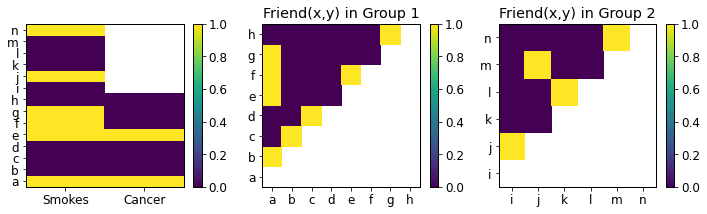

In [15]:
plt.figure(figsize=(12,3))
plt.subplot(131)
plt_heatmap(df_smokes_cancer_facts, vmin=0, vmax=1)
plt.subplot(132)
plt.title("Friend(x,y) in Group 1")
plt_heatmap(df_friends_ah_facts, vmin=0, vmax=1)
plt.subplot(133)
plt.title("Friend(x,y) in Group 2")
plt_heatmap(df_friends_in_facts, vmin=0, vmax=1)
#plt.savefig('ex_smokes_givenfacts.pdf')
plt.show()

Querying all the truth-values using LTN after training: smokers and cancer (left), friendship relations (middle and right).

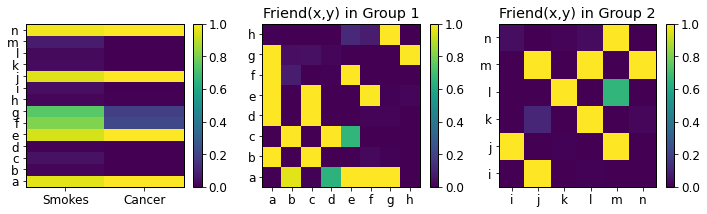

In [16]:
plt.figure(figsize=(12,3))
plt.subplot(131)
plt_heatmap(df_smokes_cancer, vmin=0, vmax=1)
plt.subplot(132)
plt.title("Friend(x,y) in Group 1")
plt_heatmap(df_friends_ah, vmin=0, vmax=1)
plt.subplot(133)
plt.title("Friend(x,y) in Group 2")
plt_heatmap(df_friends_in, vmin=0, vmax=1)
#plt.savefig('ex_smokes_inferfacts.pdf')
plt.show()

Satisfiability of the axioms.

In [17]:
print("forall p: ~Friends(p,p) : %.2f" % Forall(p,Not(Friends([p,p]))).tensor)
print("forall p,q: Friends(p,q) -> Friends(q,p) : %.2f" % Forall((p,q),Implies(Friends([p,q]),Friends([q,p]))).tensor)
print("forall p: exists q: Friends(p,q) : %.2f" % Forall(p,Exists(q,Friends([p,q]))).tensor)
print("forall p,q: Friends(p,q) -> (Smokes(p)->Smokes(q)) : %.2f" % Forall((p,q),Implies(Friends([p,q]),Implies(Smokes(p),Smokes(q)))).tensor)
print("forall p: Smokes(p) -> Cancer(p) : %.2f" % Forall(p,Implies(Smokes(p),Cancer(p))).tensor)

forall p: ~Friends(p,p) : 1.00
forall p,q: Friends(p,q) -> Friends(q,p) : 0.95
forall p: exists q: Friends(p,q) : 0.80
forall p,q: Friends(p,q) -> (Smokes(p)->Smokes(q)) : 0.78
forall p: Smokes(p) -> Cancer(p) : 0.76


We can query unknown formulas.

In [18]:
print("forall p: Cancer(p) -> Smokes(p): %.2f" % Forall(p,Implies(Cancer(p),Smokes(p)),p=5).tensor)
print("forall p,q: (Cancer(p) or Cancer(q)) -> Friends(p,q): %.2f" % Forall((p,q), Implies(Or(Cancer(p),Cancer(q)),Friends([p,q])),p=5).tensor)

forall p: Cancer(p) -> Smokes(p): 0.96
forall p,q: (Cancer(p) or Cancer(q)) -> Friends(p,q): 0.22


# Visualize the embeddings

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [20]:
x = [c.tensor.numpy() for c in g.values()]
x_norm = StandardScaler().fit_transform(x)

In [21]:
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(x_norm)

In [22]:
var_x = ltn.Variable("x",x)
var_x1 = ltn.Variable("x1",x)
var_x2 = ltn.Variable("x2",x)

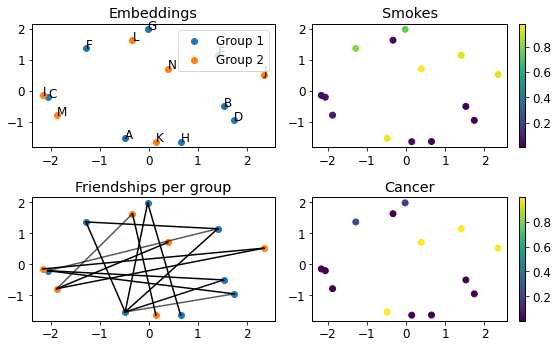

In [23]:
plt.figure(figsize=(8,5))
plt.subplot(221)
plt.scatter(pca_transformed[:len(g1.values()),0],pca_transformed[:len(g1.values()),1],label="Group 1")
plt.scatter(pca_transformed[len(g1.values()):,0],pca_transformed[len(g1.values()):,1],label="Group 2")
names = list(g.keys())
for i in range(len(names)):
    plt.annotate(names[i].upper(),pca_transformed[i])
plt.title("Embeddings")
plt.legend()

plt.subplot(222)
plt.scatter(pca_transformed[:,0],pca_transformed[:,1],c=Smokes(var_x).tensor)
plt.title("Smokes")
plt.colorbar()

plt.subplot(224)
plt.scatter(pca_transformed[:,0],pca_transformed[:,1],c=Cancer(var_x).tensor)
plt.title("Cancer")
plt.colorbar()

plt.subplot(223)
plt.scatter(pca_transformed[:len(g1.values()),0],pca_transformed[:len(g1.values()),1],label="Group 1")
plt.scatter(pca_transformed[len(g1.values()):,0],pca_transformed[len(g1.values()):,1],label="Group 2")
res = Friends([var_x1,var_x2]).tensor.numpy()
for i1 in range(len(x)):
    for i2 in range(i1,len(x)):
        if (names[i1] in g1 and names[i2] in g2) \
            or (names[i1] in g2 and names[i2] in g1):
            continue
        plt.plot(
            [pca_transformed[i1,0],pca_transformed[i2,0]],
            [pca_transformed[i1,1],pca_transformed[i2,1]],
            alpha=res[i1,i2],c="black")
plt.title("Friendships per group")
plt.tight_layout()
#plt.savefig("ex_smokes_embeddings.pdf")